<a href="https://colab.research.google.com/github/IT21388934/code_emberding_using_codeBERT/blob/main/gradingModel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install scikit-learn pandas transformers


In [40]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [41]:
# Load the pre-trained CodeBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [43]:
# Function to get embeddings for Java cod
def get_code_embedding(code):
    # Move input to the same device as the model
    inputs = tokenizer(code, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state[:, 0, :].cpu().numpy()  # Move to CPU after computation
    return embeddings.flatten()

In [44]:
url = '/content/drive/MyDrive/AI_ML/projectModel/model2/java_code_submissions_large_new.csv'
data = pd.read_csv(url)


# Print the total number of rows (data entries)
print("Total number of data entries (rows):", data.shape[0])



Total number of data entries (rows): 10000


In [45]:
# Generate embeddings for the dataset
data['code_embedding'] = data['code'].apply(lambda x: get_code_embedding(x))

# Check if the embeddings have consistent lengths
embedding_lengths = data['code_embedding'].apply(lambda x: len(x))
print(embedding_lengths.value_counts())  # Ensure consistent length of embeddings

# Find the maximum length of the embeddings
max_len = max(data['code_embedding'].apply(len))

# Pad or truncate each embedding to have the same length
X = np.array([np.pad(embedding, (0, max_len - len(embedding))) if len(embedding) < max_len else embedding[:max_len] for embedding in data['code_embedding']])

# Check the shape of X
print("Shape of X:", X.shape)

# Prepare features (X) and labels (y)
y = data['grade']

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree Regressor on the training set
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Validate the model on the testing set
y_pred = model.predict(X_test)
print("MSE (Test Data):", mean_squared_error(y_test, y_pred))

code_embedding
768    10000
Name: count, dtype: int64
Shape of X: (10000, 768)
MSE (Test Data): 880.5703849717593


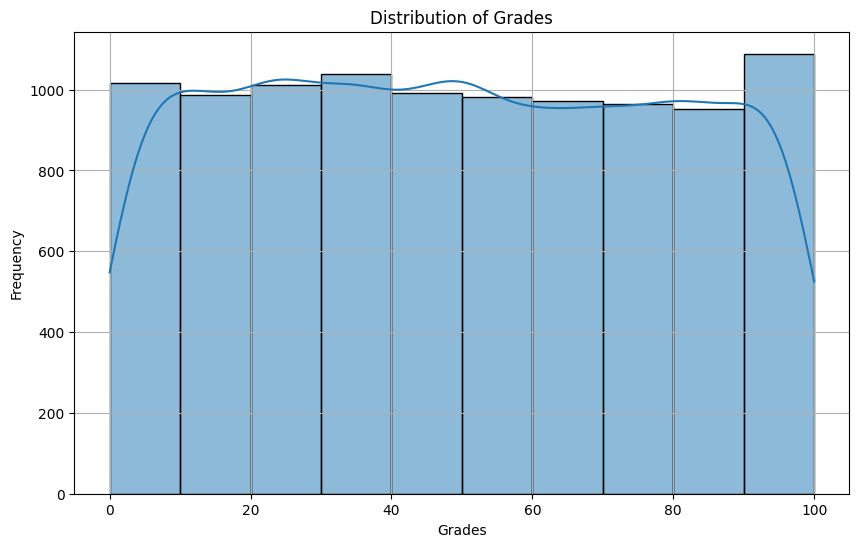

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of grades
plt.figure(figsize=(10, 6))
sns.histplot(data['grade'], bins=10, kde=True)
plt.title('Distribution of Grades')
plt.xlabel('Grades')
plt.ylabel('Frequency')
plt.grid()
plt.show()


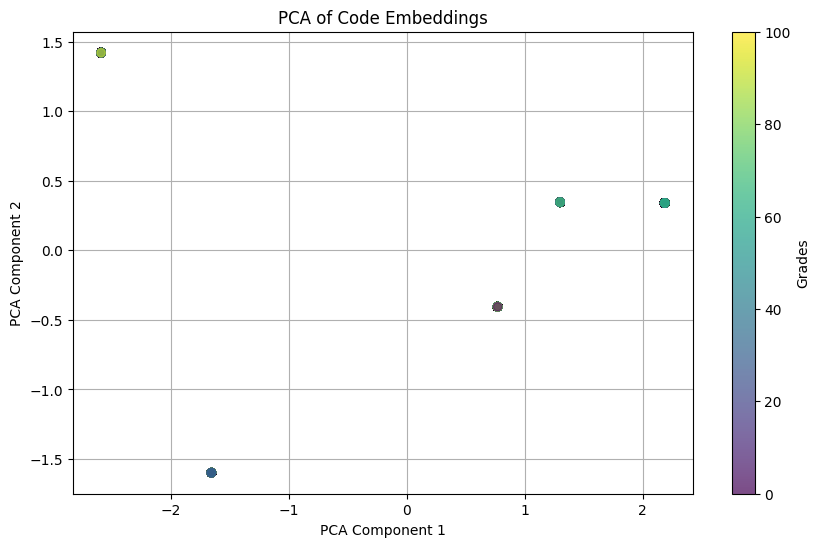

In [47]:
from sklearn.decomposition import PCA

# Reduce dimensionality of the embeddings
pca = PCA(n_components=2)
X_embedded = pca.fit_transform(X)

# Visualize the embeddings
plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(label='Grades')
plt.title('PCA of Code Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()


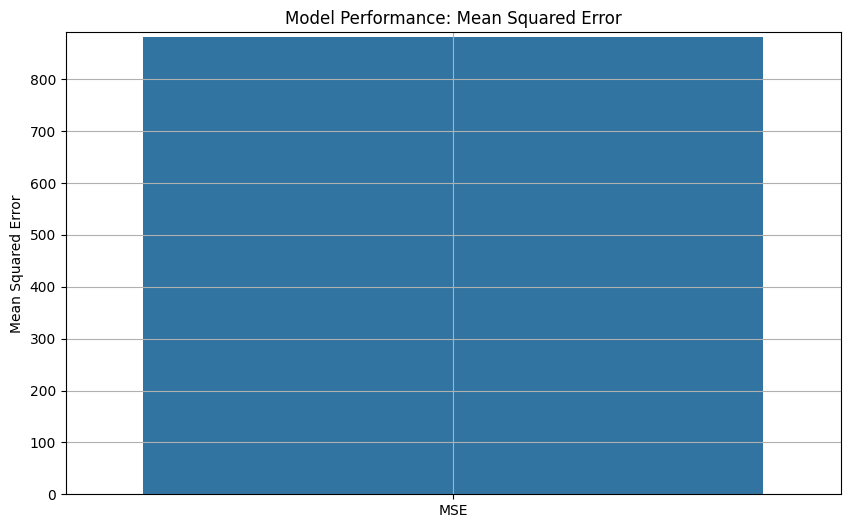

In [48]:
from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Visualize Model Performance
plt.figure(figsize=(10, 6))
sns.barplot(x=['MSE'], y=[mse])
plt.title('Model Performance: Mean Squared Error')
plt.ylabel('Mean Squared Error')
plt.ylim(0, max(mse + 10, 100))  # Adjust limits as needed
plt.grid()
plt.show()


In [49]:
import plotly.express as px

fig = px.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1], color=y, labels={'x': 'PCA Component 1', 'y': 'PCA Component 2'})
fig.update_layout(title='Interactive PCA of Code Embeddings')
fig.show()
